This notebook is to train a Variational Autoencoder on Model Parameters dataset, but align the latent variables with the angle of the corresponding model.

In [2]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

from src.data.datasets import ModelParamsDataset

from src.data.helpers import get_moons_dataset, rotate, get_accuracy, find_closest_vectors
from src.model.models import DBModel, VAE

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from src.visualization.visualize import plot_decision_boundary

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

import math
import timeit


In [3]:
def eight_normal_sample(centers, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(2), math.sqrt(var) * torch.eye(2)
    )
    n = centers.shape[0]
    centers = centers * scale
    noise = m.sample((n,)).to(centers.device)
    data = []
    for i in range(n):
        data.append(centers[i] + noise[i])
    data = torch.stack(data)
    return data

def loss_fn(x, x_hat, mean, log_var, kdl_weight=40):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + kdl_weight*KLD

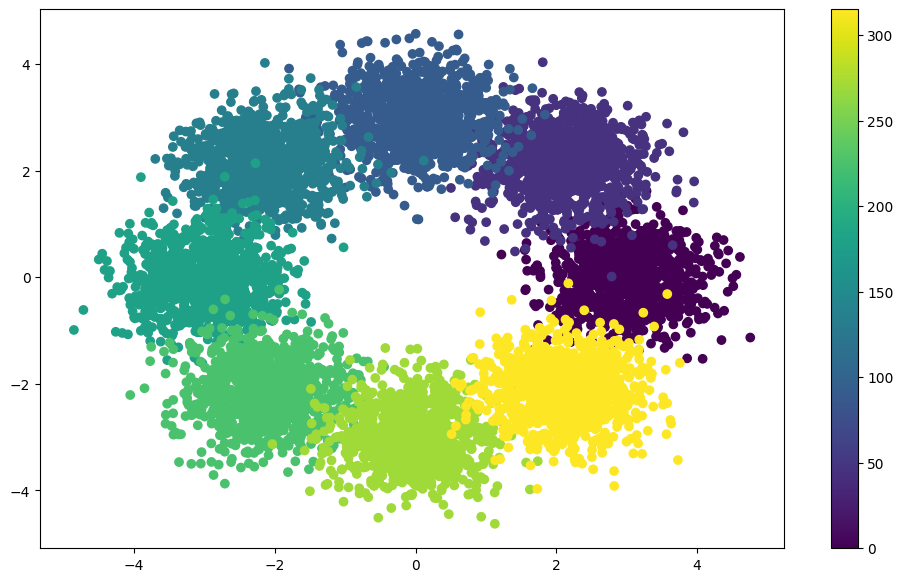

In [4]:
n_samples = 1000
angles = [0] * n_samples + [45] * n_samples + [90] * n_samples + [135] * n_samples + [180] * n_samples + [225] * n_samples + [270] * n_samples + [315] * n_samples
centers = [(np.cos(a * np.pi / 180), np.sin(a * np.pi / 180)) for a in angles]
centers = torch.tensor(centers).reshape(-1, 2)
r = eight_normal_sample(centers, scale=3, var=0.1)

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot()
img = ax.scatter(r[:, 0], r[:, 1], c=angles, cmap="viridis")
fig.colorbar(img)

## 10000 samples per angle

In [36]:
# Hyperparameters
epochs = 50
kdl_weight = 1
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 0
latent_dim = 2
in_out_dim = 33
dropout = 0.2

torch.manual_seed(random_seed)

# Model
autoencoder = VAE(in_out_dim, latent_dim, dropout)
model = DBModel()

autoencoder.to(device)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Dataset
dataset = ModelParamsDataset("../../data/eight_angles_small.csv")
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Grid of points 100x100
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
input = np.c_[xx.ravel(), yy.ravel()]
input = torch.tensor(input, dtype=torch.float32)
input = input.unsqueeze(0).repeat(batch_size, 1, 1)
input = input.to(device)

# Locations
path = "../../models/autoencoders/vae_dbloss_aligned"
model_path = "{}/vae.pth".format(path, kdl_weight)

In [12]:
autoencoder.train()
losses = []
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for (parameters_batch, angles_batch) in dataloader:
        # Model prediction
        parameters_batch = parameters_batch.to(device)
        angles_batch = angles_batch.to(device)

        angles_batch = angles_batch * math.pi / 180
        sin = torch.sin(angles_batch)
        cos = torch.cos(angles_batch)
        centers = torch.stack([cos, sin], dim=1)
        aligned_centers = eight_normal_sample(centers, scale=3, var=0.1).to(device)

        encoded = autoencoder.encoder(parameters_batch)

        means = autoencoder.mu(encoded)
        logvars = autoencoder.logvar(encoded)
        latent = autoencoder.reparameterize(means, logvars)

        reconstructed = autoencoder.decoder(latent)
        
        # reconstructed, mean, logvar = autoencoder(parameters_batch)
        output = model(reconstructed, input)

        # Ground truth
        goal = model(parameters_batch, input)

        optimizer.zero_grad()
        loss = loss_fn(goal, output, means, logvars, kdl_weight)
        means_loss = nn.functional.mse_loss(latent, aligned_centers)
        loss += (means_loss * 1e5)
        loss.backward()
        total_loss += loss.item()
    
        optimizer.step()
        
    print(f"Epoch {epoch} - Loss: {total_loss}")
    losses.append(total_loss)

torch.save(autoencoder.state_dict(), model_path)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 - Loss: 605343141.3125
Epoch 1 - Loss: 304081012.09375
Epoch 2 - Loss: 243044174.28125
Epoch 3 - Loss: 212660979.140625
Epoch 4 - Loss: 196441611.59375
Epoch 5 - Loss: 201172769.9375
Epoch 6 - Loss: 188826463.09375
Epoch 7 - Loss: 177659719.515625
Epoch 8 - Loss: 189090680.078125
Epoch 9 - Loss: 178355268.609375
Epoch 10 - Loss: 170015525.09375
Epoch 11 - Loss: 159663901.765625
Epoch 12 - Loss: 155906824.75
Epoch 13 - Loss: 155066383.21875
Epoch 14 - Loss: 154480488.5625
Epoch 15 - Loss: 154191823.90625
Epoch 16 - Loss: 153447576.078125
Epoch 17 - Loss: 152634185.421875
Epoch 18 - Loss: 151969654.125
Epoch 19 - Loss: 151262533.15625
Epoch 20 - Loss: 149708983.796875
Epoch 21 - Loss: 150051238.390625
Epoch 22 - Loss: 148395564.640625
Epoch 23 - Loss: 150249631.015625
Epoch 24 - Loss: 147745568.734375
Epoch 25 - Loss: 148915494.140625
Epoch 26 - Loss: 148274806.015625
Epoch 27 - Loss: 146430300.4375
Epoch 28 - Loss: 147422788.765625
Epoch 29 - Loss: 147167352.5625
Epoch 30 - Loss

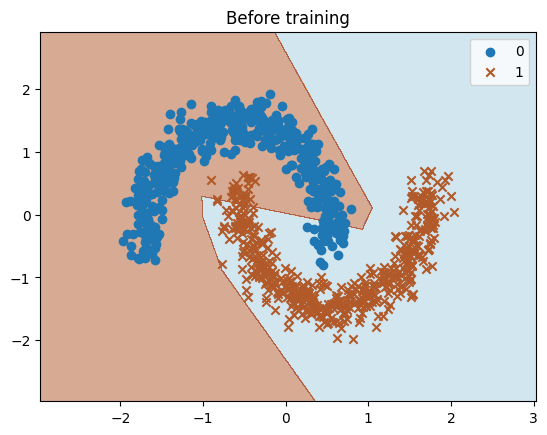

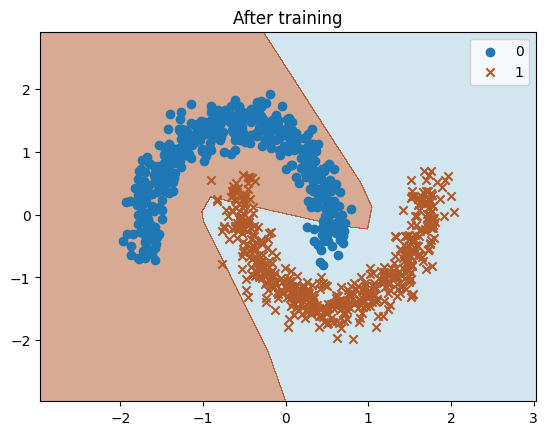

In [7]:
autoencoder = VAE(in_out_dim, latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

index = 12250
sample = eight_normal_sample(torch.tensor([[1, 1]]), scale=3, var=0.1)

parameters = dataset[index][0]
reconstructed, _, _ = autoencoder(parameters.unsqueeze(0))
reconstructed = reconstructed.squeeze()
X, y = get_moons_dataset()
plot_decision_boundary(parameters, X, y, title="Before training")
plot_decision_boundary(reconstructed, X, y, title="After training")

## 10 spa

In [5]:
# Hyperparameters
epochs = 50
kdl_weight = 1
batch_size = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 0
latent_dim = 2
in_out_dim = 33
dropout = 0.2

torch.manual_seed(random_seed)

# Model
autoencoder = VAE(in_out_dim, latent_dim, dropout)
model = DBModel()

autoencoder.to(device)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Dataset
dataset = ModelParamsDataset("../../data/eight_angles_small.csv", get_per_angle=10)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Grid of points 100x100
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
input = np.c_[xx.ravel(), yy.ravel()]
input = torch.tensor(input, dtype=torch.float32)
input = input.unsqueeze(0).repeat(batch_size, 1, 1)
input = input.to(device)

# Locations
path = "../../models/autoencoders/vae_dbloss_aligned"
model_path = "{}/vae_10spa.pth".format(path, kdl_weight)

In [14]:
autoencoder.train()
losses = []
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for (parameters_batch, angles_batch) in dataloader:
        # Model prediction
        parameters_batch = parameters_batch.to(device)
        angles_batch = angles_batch.to(device)

        angles_batch = angles_batch * math.pi / 180
        sin = torch.sin(angles_batch)
        cos = torch.cos(angles_batch)
        centers = torch.stack([cos, sin], dim=1)
        aligned_centers = eight_normal_sample(centers, scale=3, var=0.1).to(device)

        encoded = autoencoder.encoder(parameters_batch)

        means = autoencoder.mu(encoded)
        logvars = autoencoder.logvar(encoded)
        latent = autoencoder.reparameterize(means, logvars)

        reconstructed = autoencoder.decoder(latent)
        
        # reconstructed, mean, logvar = autoencoder(parameters_batch)
        output = model(reconstructed, input)

        # Ground truth
        goal = model(parameters_batch, input)

        optimizer.zero_grad()
        loss = loss_fn(goal, output, means, logvars, kdl_weight)
        means_loss = nn.functional.mse_loss(latent, aligned_centers)
        loss += (means_loss * 1e5)
        loss.backward()
        total_loss += loss.item()
    
        optimizer.step()
        
    print(f"Epoch {epoch} - Loss: {total_loss}")
    losses.append(total_loss)

torch.save(autoencoder.state_dict(), model_path)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 - Loss: 3483845.75
Epoch 1 - Loss: 3350179.3125
Epoch 2 - Loss: 3475621.9375
Epoch 3 - Loss: 2712955.0625
Epoch 4 - Loss: 2607510.25
Epoch 5 - Loss: 2742751.0625
Epoch 6 - Loss: 2532266.4375
Epoch 7 - Loss: 2372349.1875
Epoch 8 - Loss: 2567751.0
Epoch 9 - Loss: 2414054.4375
Epoch 10 - Loss: 2941187.0625
Epoch 11 - Loss: 2373979.9375
Epoch 12 - Loss: 2146280.25
Epoch 13 - Loss: 2199367.125
Epoch 14 - Loss: 2400712.875
Epoch 15 - Loss: 2283621.875
Epoch 16 - Loss: 2244010.53125
Epoch 17 - Loss: 2267909.0625
Epoch 18 - Loss: 2153226.0625
Epoch 19 - Loss: 1986107.4375
Epoch 20 - Loss: 1952114.90625
Epoch 21 - Loss: 2132469.53125
Epoch 22 - Loss: 2009544.71875
Epoch 23 - Loss: 1947833.3125
Epoch 24 - Loss: 2088297.5625
Epoch 25 - Loss: 2009689.65625
Epoch 26 - Loss: 2043641.0625
Epoch 27 - Loss: 1944094.8125
Epoch 28 - Loss: 1987423.15625
Epoch 29 - Loss: 1947128.75
Epoch 30 - Loss: 1978905.21875
Epoch 31 - Loss: 1996732.125
Epoch 32 - Loss: 2043847.4375
Epoch 33 - Loss: 2112909.031

## 100 spa

In [15]:
# Hyperparameters
epochs = 50
kdl_weight = 1
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 0
latent_dim = 2
in_out_dim = 33
dropout = 0.2

torch.manual_seed(random_seed)

# Model
autoencoder = VAE(in_out_dim, latent_dim, dropout)
model = DBModel()

autoencoder.to(device)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Dataset
dataset = ModelParamsDataset("../../data/eight_angles_small.csv", get_per_angle=100)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Grid of points 100x100
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
input = np.c_[xx.ravel(), yy.ravel()]
input = torch.tensor(input, dtype=torch.float32)
input = input.unsqueeze(0).repeat(batch_size, 1, 1)
input = input.to(device)

# Locations
path = "../../models/autoencoders/vae_dbloss_aligned"
model_path = "{}/vae_100spa.pth".format(path, kdl_weight)

In [16]:
autoencoder.train()
losses = []
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for (parameters_batch, angles_batch) in dataloader:
        # Model prediction
        parameters_batch = parameters_batch.to(device)
        angles_batch = angles_batch.to(device)

        angles_batch = angles_batch * math.pi / 180
        sin = torch.sin(angles_batch)
        cos = torch.cos(angles_batch)
        centers = torch.stack([cos, sin], dim=1)
        aligned_centers = eight_normal_sample(centers, scale=3, var=0.1).to(device)

        encoded = autoencoder.encoder(parameters_batch)

        means = autoencoder.mu(encoded)
        logvars = autoencoder.logvar(encoded)
        latent = autoencoder.reparameterize(means, logvars)

        reconstructed = autoencoder.decoder(latent)
        
        # reconstructed, mean, logvar = autoencoder(parameters_batch)
        output = model(reconstructed, input)

        # Ground truth
        goal = model(parameters_batch, input)

        optimizer.zero_grad()
        loss = loss_fn(goal, output, means, logvars, kdl_weight)
        means_loss = nn.functional.mse_loss(latent, aligned_centers)
        loss += (means_loss * 1e5)
        loss.backward()
        total_loss += loss.item()
    
        optimizer.step()
        
    print(f"Epoch {epoch} - Loss: {total_loss}")
    losses.append(total_loss)

torch.save(autoencoder.state_dict(), model_path)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 - Loss: 13211792.125
Epoch 1 - Loss: 12576786.0
Epoch 2 - Loss: 11577158.0
Epoch 3 - Loss: 11034052.625
Epoch 4 - Loss: 10520746.375
Epoch 5 - Loss: 10110260.5
Epoch 6 - Loss: 9763436.5
Epoch 7 - Loss: 9429078.375
Epoch 8 - Loss: 9164891.375
Epoch 9 - Loss: 8739931.9375
Epoch 10 - Loss: 8460903.75
Epoch 11 - Loss: 8447883.8125
Epoch 12 - Loss: 8429825.4375
Epoch 13 - Loss: 8192282.375
Epoch 14 - Loss: 8310021.3125
Epoch 15 - Loss: 8082773.625
Epoch 16 - Loss: 7930415.0
Epoch 17 - Loss: 8199219.6875
Epoch 18 - Loss: 7908164.25
Epoch 19 - Loss: 7706969.125
Epoch 20 - Loss: 7853447.9375
Epoch 21 - Loss: 7497313.1875
Epoch 22 - Loss: 7598113.625
Epoch 23 - Loss: 7436147.9375
Epoch 24 - Loss: 7286505.25
Epoch 25 - Loss: 7165841.75
Epoch 26 - Loss: 6948595.9375
Epoch 27 - Loss: 6714287.75
Epoch 28 - Loss: 6602436.0
Epoch 29 - Loss: 6330209.0625
Epoch 30 - Loss: 6121021.3125
Epoch 31 - Loss: 6193095.8125
Epoch 32 - Loss: 5972482.9375
Epoch 33 - Loss: 5614578.125
Epoch 34 - Loss: 53041

## 1000 spa

In [30]:
# Hyperparameters
epochs = 50
kdl_weight = 1
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 0
latent_dim = 2
in_out_dim = 33
dropout = 0.2

torch.manual_seed(random_seed)

# Model
autoencoder = VAE(in_out_dim, latent_dim, dropout)
model = DBModel()

autoencoder.to(device)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Dataset
dataset = ModelParamsDataset("../../data/eight_angles_small.csv", get_per_angle=1000)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Grid of points 100x100
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
input = np.c_[xx.ravel(), yy.ravel()]
input = torch.tensor(input, dtype=torch.float32)
input = input.unsqueeze(0).repeat(batch_size, 1, 1)
input = input.to(device)

# Locations
path = "../../models/autoencoders/vae_dbloss_aligned"
model_path = "{}/vae_1000spa.pth".format(path, kdl_weight)

In [18]:
autoencoder.train()
losses = []
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for (parameters_batch, angles_batch) in dataloader:
        # Model prediction
        parameters_batch = parameters_batch.to(device)
        angles_batch = angles_batch.to(device)

        angles_batch = angles_batch * math.pi / 180
        sin = torch.sin(angles_batch)
        cos = torch.cos(angles_batch)
        centers = torch.stack([cos, sin], dim=1)
        aligned_centers = eight_normal_sample(centers, scale=3, var=0.1).to(device)

        encoded = autoencoder.encoder(parameters_batch)

        means = autoencoder.mu(encoded)
        logvars = autoencoder.logvar(encoded)
        latent = autoencoder.reparameterize(means, logvars)

        reconstructed = autoencoder.decoder(latent)
        
        # reconstructed, mean, logvar = autoencoder(parameters_batch)
        output = model(reconstructed, input)

        # Ground truth
        goal = model(parameters_batch, input)

        optimizer.zero_grad()
        loss = loss_fn(goal, output, means, logvars, kdl_weight)
        means_loss = nn.functional.mse_loss(latent, aligned_centers)
        loss += (means_loss * 1e5)
        loss.backward()
        total_loss += loss.item()
    
        optimizer.step()
        
    print(f"Epoch {epoch} - Loss: {total_loss}")
    losses.append(total_loss)

torch.save(autoencoder.state_dict(), model_path)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 - Loss: 108411622.375
Epoch 1 - Loss: 84794594.625
Epoch 2 - Loss: 75160869.4375
Epoch 3 - Loss: 60675728.1875
Epoch 4 - Loss: 50538176.1875
Epoch 5 - Loss: 45566093.0
Epoch 6 - Loss: 42043060.84375
Epoch 7 - Loss: 39607100.71875
Epoch 8 - Loss: 37475428.1875
Epoch 9 - Loss: 35200041.125
Epoch 10 - Loss: 34338840.5625
Epoch 11 - Loss: 32107155.46875
Epoch 12 - Loss: 30562545.125
Epoch 13 - Loss: 29860939.0625
Epoch 14 - Loss: 28466877.28125
Epoch 15 - Loss: 27470175.3125
Epoch 16 - Loss: 26220639.4375
Epoch 17 - Loss: 26081472.5625
Epoch 18 - Loss: 28575900.6875
Epoch 19 - Loss: 25155010.0
Epoch 20 - Loss: 23787174.28125
Epoch 21 - Loss: 24759558.65625
Epoch 22 - Loss: 26175407.703125
Epoch 23 - Loss: 26478976.875
Epoch 24 - Loss: 22377774.75
Epoch 25 - Loss: 23511894.515625
Epoch 26 - Loss: 22150078.984375
Epoch 27 - Loss: 21048911.640625
Epoch 28 - Loss: 21311955.40625
Epoch 29 - Loss: 21011185.859375
Epoch 30 - Loss: 19817945.53125
Epoch 31 - Loss: 21238277.28125
Epoch 32 - 

## Latent Space

(80000, 2)


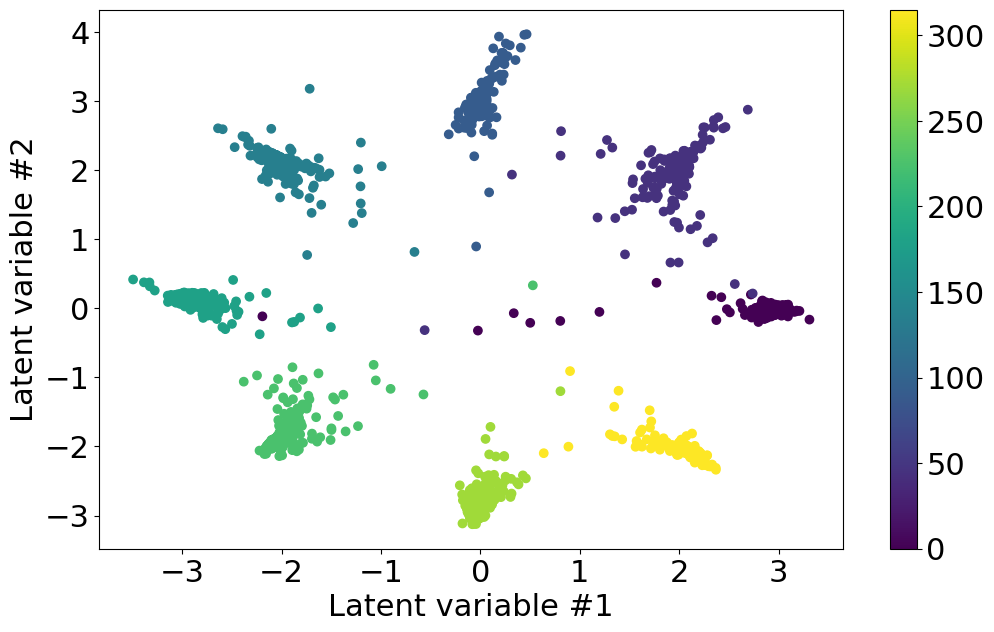

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Make text bigger in the plot
plt.rcParams.update({'font.size': 22})

model_path = "../../models/autoencoders/vae_dbloss_aligned/vae.pth"
autoencoder = VAE(in_out_dim, latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

raw = pd.read_csv("../../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

raw_unseen = pd.read_csv("../../data/extra_angles.csv")
weights_unseen = raw_unseen.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles_unseen = raw_unseen["angle"].to_numpy()

# Join both weights
# weights = np.vstack([weights, weights_unseen])
# angles = np.hstack([angles, angles_unseen])

weights = torch.tensor(weights).float()
latent, mean, logvar = autoencoder(weights)
latent = autoencoder.reparameterize(mean, logvar).detach().numpy()
latent = mean.detach().numpy()
print(latent.shape)

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot()
img = ax.scatter(latent[:, 0], latent[:, 1], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')


# plt.title("Latent Space")
plt.xlabel("Latent variable #1")
plt.ylabel("Latent variable #2")
plt.savefig("../../reports/vae-latent-space-mini.pdf", bbox_inches='tight')
plt.show()

## Reconstructed weights distribution

In [35]:
print(dataset[0][0].unsqueeze(0))

tensor([[ 2.9519,  1.4027, -0.1612,  2.2043, -3.7474,  0.8730, -0.1507,  1.6691,
          2.8337, -2.5433,  1.3250,  0.5758,  4.2214,  0.5225, -1.9792,  0.1241,
          1.5305, -1.2668, -2.2178, -0.9761, -2.1477, -0.6531, -2.0133,  1.2496,
         -3.4469, -1.1058, -4.0333, -0.8703,  1.8764,  1.1630,  4.0624,  1.3364,
          3.2853]])


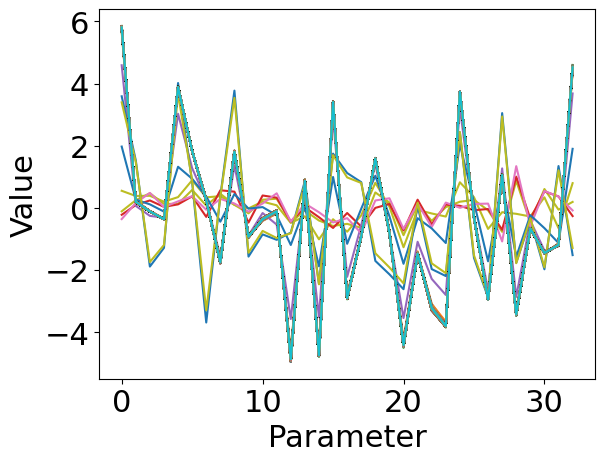

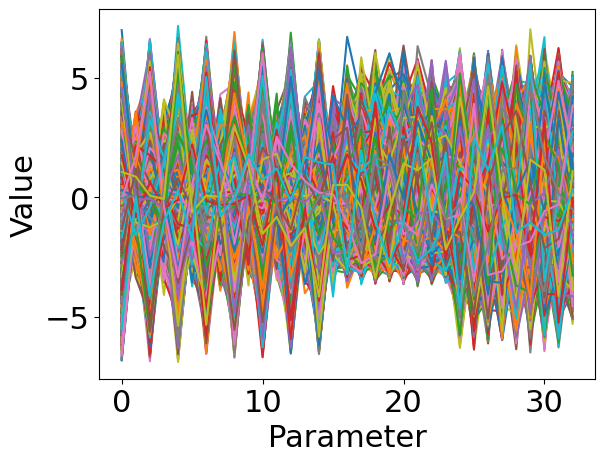

In [41]:
from matplotlib import pyplot as plt

plt.rcParams.update({"font.size": 22})

model = VAE(in_out_dim, latent_dim, dropout)
model.load_state_dict(torch.load(model_path))
model.eval()

orignial = []
reconstruction = []
for i in range(10000):
    parameters = dataset[i][0].unsqueeze(0)
    r, _, _ = model(parameters)
    r = r.squeeze().detach().numpy()
    reconstruction.append(r)
    orignial.append(parameters.squeeze().detach().numpy())


for r in reconstruction:
    plt.plot(r)

plt.xlabel("Parameter")
plt.ylabel("Value")
# plt.title("Parameter values after autoencoder")
plt.savefig("../../reports/vae-reconstruction-distribution.pdf", bbox_inches='tight')
plt.show()
plt.close()

for r in orignial:
    plt.plot(r)

plt.xlabel("Parameter")
plt.ylabel("Value")
plt.savefig("../../reports/vae-original-parameters-distribution.pdf", bbox_inches='tight')
# plt.title("Parameter values before autoencoder")
plt.show()
plt.close()

## Accuracy distribution

  0%|          | 0/16000 [00:00<?, ?it/s]

Mean trained accuracy: 99.8715
Mean reconstructed accuracy: 99.71186875


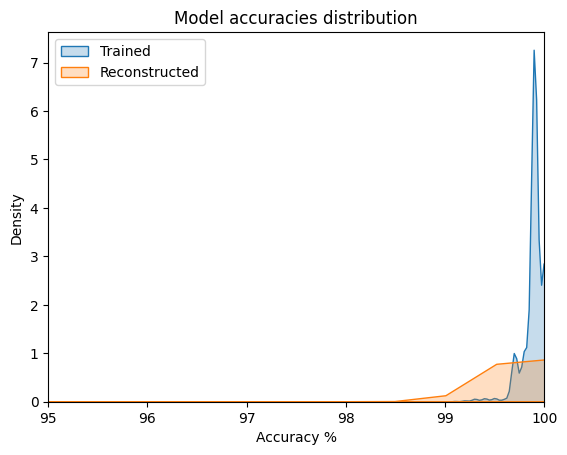

In [49]:
autoencoder = VAE(in_out_dim, latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

trained_accuracies = []
reconstructed_accuracies = []

X, y = get_moons_dataset()

for (parameter, angle) in tqdm(test_dataset):
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float().unsqueeze(0)

    accuracy = get_accuracy(parameter, X_rotated, y)
    trained_accuracies.append(accuracy)

    reconstructed, _, _ = autoencoder(parameter.unsqueeze(0))
    reconstructed = reconstructed.squeeze()
    accuracy = get_accuracy(reconstructed, X_rotated, y)
    reconstructed_accuracies.append(accuracy)

print(f"Mean trained accuracy: {np.mean(trained_accuracies)}")
print(f"Mean reconstructed accuracy: {np.mean(reconstructed_accuracies)}")

sns.kdeplot(trained_accuracies, fill=True, label="Trained")
sns.kdeplot(reconstructed_accuracies, fill=True, label="Reconstructed")

plt.legend(loc="upper left")
plt.title("Model accuracies distribution")
plt.xlabel("Accuracy %")
plt.xlim(95, 100)
plt.show()


## Interpolation

  0%|          | 0/7 [00:00<?, ?it/s]

Mean interpolation accuracy: 98.57087999999999


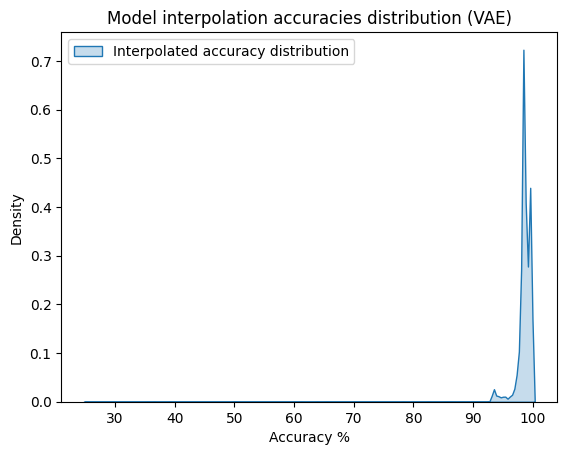

In [51]:
autoencoder = VAE(in_out_dim, latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

raw = pd.read_csv("../../data/eight_angles_small.csv")
weights_0 = raw.loc[raw["angle"] == 0].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_45 = raw.loc[raw["angle"] == 45].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_90 = raw.loc[raw["angle"] == 90].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_135 = raw.loc[raw["angle"] == 135].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_180 = raw.loc[raw["angle"] == 180].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_225 = raw.loc[raw["angle"] == 225].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_270 = raw.loc[raw["angle"] == 270].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_315 = raw.loc[raw["angle"] == 315].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()

weights = [weights_0, weights_45, weights_90, weights_135, weights_180, weights_225, weights_270, weights_315]
angles = [0, 45, 90, 135, 180, 225, 270, 315]

X, y = get_moons_dataset()
accuracies = []
bad_accuracy = []

for i in tqdm(range(0, 7)):
    for j in range(10000):
        weight_1 = weights[i][j]
        weight_2 = weights[i+1][j]
        angle_1 = angles[i]
        angle_2 = angles[i+1]

        alpha = np.random.uniform(0.4, 0.6)

        latent_1 = autoencoder.encoder(torch.tensor(weight_1).float().unsqueeze(0))
        mean_1 = autoencoder.mu(latent_1)
        logvar_1 = autoencoder.logvar(latent_1)
        latent_1 = autoencoder.reparameterize(mean_1, logvar_1)

        latent_2 = autoencoder.encoder(torch.tensor(weight_2).float().unsqueeze(0))
        mean_2 = autoencoder.mu(latent_2)
        logvar_2 = autoencoder.logvar(latent_2)
        latent_2 = autoencoder.reparameterize(mean_2, logvar_2)

        latent = (1-alpha)*latent_1 + alpha*latent_2
        angle = (1-alpha)*angle_1 + alpha*angle_2

        w = autoencoder.decoder(latent).squeeze()
        X_rotated = rotate(X, angle)
        X_rotated = torch.tensor(X_rotated).float()
        accuracy = get_accuracy(w, X_rotated, y)
        # if(accuracy < 50):
        #     print(i)
        #     print(i+1)
        #     print(j)
        accuracies.append(accuracy)
    
print("Mean interpolation accuracy:", np.mean(accuracies))

sns.kdeplot(accuracies, fill=True, label="Interpolated accuracy distribution")

plt.legend(loc="upper left")
plt.title("Model interpolation accuracies distribution (VAE)")
plt.xlabel("Accuracy %")
plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

Mean interpolation accuracy: 98.57251714285717


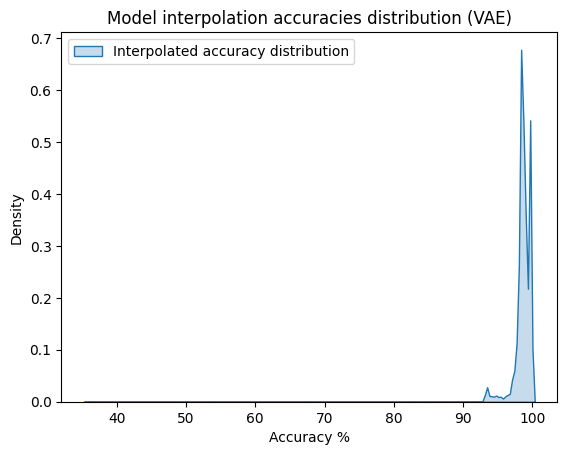

In [52]:
autoencoder = VAE(in_out_dim, latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

raw = pd.read_csv("../../data/eight_angles_small.csv")
weights_0 = raw.loc[raw["angle"] == 0].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_45 = raw.loc[raw["angle"] == 45].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_90 = raw.loc[raw["angle"] == 90].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_135 = raw.loc[raw["angle"] == 135].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_180 = raw.loc[raw["angle"] == 180].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_225 = raw.loc[raw["angle"] == 225].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_270 = raw.loc[raw["angle"] == 270].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_315 = raw.loc[raw["angle"] == 315].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()

weights = [weights_0, weights_45, weights_90, weights_135, weights_180, weights_225, weights_270, weights_315]
angles = [0, 45, 90, 135, 180, 225, 270, 315]

X, y = get_moons_dataset()
accuracies = []
bad_accuracy = []

for i in tqdm(range(0, 7)):
    for j in range(10000):
        weight_1 = weights[i][j]
        weight_2 = weights[i+1][j]
        angle_1 = angles[i]
        angle_2 = angles[i+1]

        alpha = np.random.uniform(0.4, 0.6)

        latent_1 = autoencoder.encoder(torch.tensor(weight_1).float().unsqueeze(0))
        latent_2 = autoencoder.encoder(torch.tensor(weight_2).float().unsqueeze(0))

        mean_1 = autoencoder.mu(latent_1)
        logvar_1 = autoencoder.logvar(latent_1)
        latent_1 = autoencoder.reparameterize(mean_1, logvar_1)

        mean_2 = autoencoder.mu(latent_2)
        logvar_2 = autoencoder.logvar(latent_2)
        latent_2 = autoencoder.reparameterize(mean_2, logvar_2)

        latent = (1-alpha)*latent_1 + alpha*latent_2
        angle = (1-alpha)*angle_1 + alpha*angle_2

        w = autoencoder.decoder(latent).squeeze()
        X_rotated = rotate(X, angle)
        X_rotated = torch.tensor(X_rotated).float()
        accuracy = get_accuracy(w, X_rotated, y)
        # if(accuracy < 50):
        #     print(i)
        #     print(i+1)
        #     print(j)
        accuracies.append(accuracy)
    
print("Mean interpolation accuracy:", np.mean(accuracies))

sns.kdeplot(accuracies, fill=True, label="Interpolated accuracy distribution")

plt.legend(loc="upper left")
plt.title("Model interpolation accuracies distribution (VAE)")
plt.xlabel("Accuracy %")
plt.show()

In [8]:
def plot_interpolation(model, datapoint_1, datapoint_2, X, y, alpha):
    parameters_1, angle_1 = datapoint_1
    parameters_2, angle_2 = datapoint_2

    parameters_1 = parameters_1.unsqueeze(0)
    parameters_2 = parameters_2.unsqueeze(0)

    latent_1 = model.encoder(parameters_1)
    mean_1 = model.mu(latent_1)
    logvar_1 = model.logvar(latent_1)
    latent_1 = model.reparameterize(mean_1, logvar_1)

    latent_2 = model.encoder(parameters_2)
    mean_2 = model.mu(latent_2)
    logvar_2 = model.logvar(latent_2)
    latent_2 = model.reparameterize(mean_2, logvar_2)

    angle_diff = angle_2 - angle_1
    # latent = np.sin((1-alpha)*angle_diff*np.pi/90)/np.sin(angle_diff*np.pi/90)*latent_1 + np.sin(alpha*angle_diff*np.pi/90)/np.sin(angle_diff*np.pi/90)*latent_2
    latent = (1-alpha)*latent_1 + alpha*latent_2

    w = model.decoder(latent).squeeze()

    angle = (1-alpha)*angle_1 + alpha*angle_2
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float()

    plot_decision_boundary(w, X_rotated, y, title=f"{angle:.2f}°")

In [11]:
autoencoder = VAE(in_out_dim, latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

dataset = ModelParamsDataset("../../data/eight_angles_small.csv")

X, y = get_moons_dataset()

alpha = 0.8
index_1 = 2
index_2 = 60000

datapoint_1 = dataset[index_1]
datapoint_2 = dataset[index_2]

interact(plot_interpolation, model=fixed(autoencoder), datapoint_1=fixed(datapoint_1), datapoint_2=fixed(datapoint_2), X=fixed(X), y=fixed(y), alpha=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5))

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.01), Output()), _dom_classes…

<function __main__.plot_interpolation(model, datapoint_1, datapoint_2, X, y, alpha)>

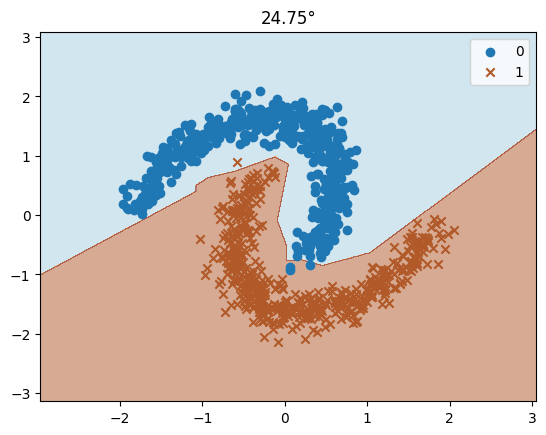

In [12]:
autoencoder = VAE(in_out_dim, latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

dataset = ModelParamsDataset("../../data/eight_angles_small.csv")

X, y = get_moons_dataset()

alpha = 0.55
index_1 = 0
index_2 = 60000

datapoint_1 = dataset[index_1]
datapoint_2 = dataset[index_2]

plot_interpolation(autoencoder, datapoint_1, datapoint_2, X, y, alpha)

## See samples accuracy

  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate 800 samples: 1.6642195000022184
Model: ../../models/autoencoders/vae_dbloss_aligned/vae_10spa.pth
Mean accuracy: 79.49887500000001
Standard deviation: 8.593332370761356
The distance in set: 2.832614302635193 0.7159800252129159
The distance between generated samples and training samples: 8.626741826534271 0.7176981833283322


  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate 800 samples: 1.6258385999972234
Model: ../../models/autoencoders/vae_dbloss_aligned/vae_100spa.pth
Mean accuracy: 87.4625
Standard deviation: 2.8674237130218496
The distance in set: 3.331889808177948 1.0649123754633316
The distance between generated samples and training samples: 8.391196429729462 0.3393213502308406


  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate 800 samples: 1.6655866999935824
Model: ../../models/autoencoders/vae_dbloss_aligned/vae_1000spa.pth
Mean accuracy: 98.47574999999999
Standard deviation: 5.059084594815548
The distance in set: 3.0488083362579346 0.7567743626913338
The distance between generated samples and training samples: 10.88644790649414 1.0458614201527587


  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate 800 samples: 1.821206099994015
Model: ../../models/autoencoders/vae_dbloss_aligned/vae.pth
Mean accuracy: 99.4445
Standard deviation: 2.087622990388831
The distance in set: 2.3931474685668945 0.9129564097073322
The distance between generated samples and training samples: 9.797763705253601 1.3482814616329537


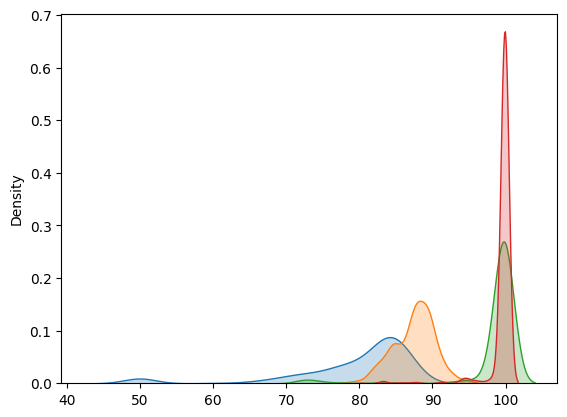

In [26]:
indexes = ["_10spa", "_100spa", "_1000spa", ""]
for index in indexes:
    model_path = f"../../models/autoencoders/vae_dbloss_aligned/vae{index}.pth"
    autoencoder = VAE(33, 2, 0.2)
    autoencoder.load_state_dict(torch.load(model_path))
    autoencoder.eval()

    angles = [0, 45, 90, 135, 180, 225, 270, 315]
    samples_per_angle = 100

    accuracies = []
    generated_parameters = []

    torch.manual_seed(42)

    start_time = timeit.default_timer()
    with torch.no_grad():
        for angle in tqdm(angles):
            good_parameters = []
            for i in range(samples_per_angle):
                a = torch.tensor([angle * math.pi / 180])
                sin = torch.sin(a)
                cos = torch.cos(a)
                center = torch.stack([cos, sin], dim=1)
                z = eight_normal_sample(center, scale=3, var=0.1)
                sample = autoencoder.decoder(z).squeeze()

                X, y = get_moons_dataset()
                X_rotated = rotate(X, angle)
                X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

                accuracy = get_accuracy(sample, X_rotated, y)
                accuracies.append(accuracy)
                if(accuracy > 80):
                    good_parameters.append(sample)
            
            generated_parameters.append(good_parameters)

    elapsed_time = timeit.default_timer() - start_time
    print(f"Time to generate {samples_per_angle*len(angles)} samples:", elapsed_time)

    average_distances = []
    for params in generated_parameters:
        params = torch.stack(params)
        dists = torch.cdist(params, params)
        average_dist = torch.mean(dists)
        average_distances.append(average_dist.item())

    set_distances_mean = np.mean(average_distances)
    set_distances_std = np.std(average_distances)

    train_params = []
    for params, angle in dataset:
        train_params.append(params)
    train_params = torch.stack(train_params)

    average_distances = []
    for params in generated_parameters:
        params = torch.stack(params)
        closest_vals,_ = find_closest_vectors(params, train_params)
        average = torch.mean(closest_vals)
        average_distances.append(average.item())

    closest_distances_mean = np.mean(average_distances)
    closest_distances_std = np.std(average_distances)
    
    print("Model:", model_path)
    print("Mean accuracy:", np.mean(accuracies))
    print("Standard deviation:", np.std(accuracies))
    print("The distance in set:", set_distances_mean, set_distances_std)
    print("The distance between generated samples and training samples:", closest_distances_mean, closest_distances_std)
    sns.kdeplot(accuracies, fill=True)

  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate 800 samples: 1.6829317999945488
Model: ../../models/autoencoders/vae_dbloss_aligned/vae_10spa.pth
Mean accuracy: 78.412
Standard deviation: 10.597223976117519
The distance in set: 2.7814502269029617 0.6781005547029748
The distance between generated samples and training samples: 8.601711928844452 0.6406678531048472


  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate 800 samples: 1.6197680000041146
Model: ../../models/autoencoders/vae_dbloss_aligned/vae_100spa.pth
Mean accuracy: 87.33775
Standard deviation: 2.9882227054722694
The distance in set: 3.3813266903162003 1.0492019765914584
The distance between generated samples and training samples: 8.348710000514984 0.3104488993928246


  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate 800 samples: 1.6413294999947539
Model: ../../models/autoencoders/vae_dbloss_aligned/vae_1000spa.pth
Mean accuracy: 96.73450000000001
Standard deviation: 4.738642711789948
The distance in set: 5.570286452770233 1.0608963033692564
The distance between generated samples and training samples: 10.439931631088257 0.7163242463025355


  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate 800 samples: 1.6617979000002379
Model: ../../models/autoencoders/vae_dbloss_aligned/vae.pth
Mean accuracy: 97.29237499999999
Standard deviation: 2.0898694598885847
The distance in set: 4.945709526538849 0.9694588000754228
The distance between generated samples and training samples: 9.366322338581085 1.0725376762208165


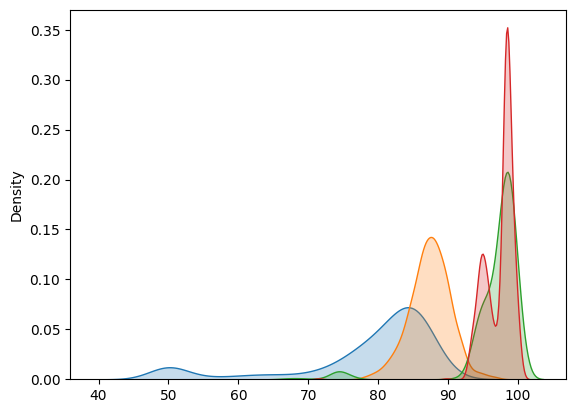

In [27]:
indexes = ["_10spa", "_100spa", "_1000spa", ""]
for index in indexes:
    model_path = f"../../models/autoencoders/vae_dbloss_aligned/vae{index}.pth"
    autoencoder = VAE(33, 2, 0.2)
    autoencoder.load_state_dict(torch.load(model_path))
    autoencoder.eval()

    angles = [45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]
    samples_per_angle = 100

    accuracies = []
    generated_parameters = []

    torch.manual_seed(42)

    start_time = timeit.default_timer()
    with torch.no_grad():
        for angle in tqdm(angles):
            good_parameters = []
            for i in range(samples_per_angle):
                a = torch.tensor([angle * math.pi / 180])
                sin = torch.sin(a)
                cos = torch.cos(a)
                center = torch.stack([cos, sin], dim=1)
                z = eight_normal_sample(center, scale=3, var=0.1)
                sample = autoencoder.decoder(z).squeeze()

                X, y = get_moons_dataset()
                X_rotated = rotate(X, angle)
                X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

                accuracy = get_accuracy(sample, X_rotated, y)
                accuracies.append(accuracy)
                if(accuracy > 80):
                    good_parameters.append(sample)
            
            generated_parameters.append(good_parameters)

    elapsed_time = timeit.default_timer() - start_time
    print(f"Time to generate {samples_per_angle*len(angles)} samples:", elapsed_time)

    average_distances = []
    for params in generated_parameters:
        params = torch.stack(params)
        dists = torch.cdist(params, params)
        average_dist = torch.mean(dists)
        average_distances.append(average_dist.item())

    set_distances_mean = np.mean(average_distances)
    set_distances_std = np.std(average_distances)

    train_params = []
    for params, angle in dataset:
        train_params.append(params)
    train_params = torch.stack(train_params)

    average_distances = []
    for params in generated_parameters:
        params = torch.stack(params)
        closest_vals,_ = find_closest_vectors(params, train_params)
        average = torch.mean(closest_vals)
        average_distances.append(average.item())

    closest_distances_mean = np.mean(average_distances)
    closest_distances_std = np.std(average_distances)
    
    print("Model:", model_path)
    print("Mean accuracy:", np.mean(accuracies))
    print("Standard deviation:", np.std(accuracies))
    print("The distance in set:", set_distances_mean, set_distances_std)
    print("The distance between generated samples and training samples:", closest_distances_mean, closest_distances_std)
    sns.kdeplot(accuracies, fill=True)

## Sample

In [9]:
autoencoder = VAE(in_out_dim, latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

index = 12250
angle = 72
X, y = get_moons_dataset()

def slider(angle):
    X_rotated = rotate(X, angle)
    angle = torch.tensor([angle * math.pi / 180])
    sin = torch.sin(angle)
    cos = torch.cos(angle)
    center = torch.stack([cos, sin], dim=1)
    sample = eight_normal_sample(center, scale=3, var=0.1)
    reconstructed = autoencoder.decoder(sample).squeeze()
    plot_decision_boundary(reconstructed, X_rotated, y, title="After training")

interact(slider, angle=widgets.IntSlider(min=0, max=360, step=1, value=0))

interactive(children=(IntSlider(value=0, description='angle', max=360), Output()), _dom_classes=('widget-inter…

<function __main__.slider(angle)>

In [6]:
plt.rcParams.update({'font.size': 22})


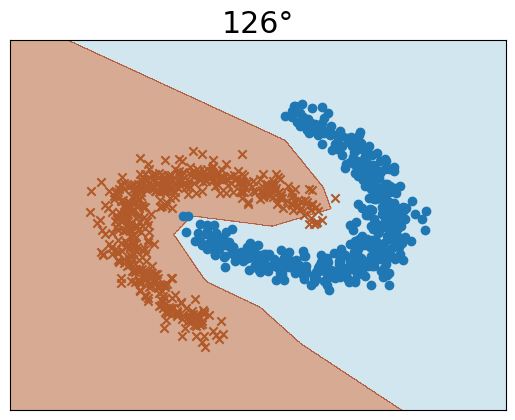

In [25]:
autoencoder = VAE(in_out_dim, latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

angle = np.random.randint(0, 360)
X, y = get_moons_dataset()

X_rotated = rotate(X, angle)
rads = torch.tensor([angle * math.pi / 180])
sin = torch.sin(rads)
cos = torch.cos(rads)
center = torch.stack([cos, sin], dim=1)
sample = eight_normal_sample(center, scale=3, var=0.1)
reconstructed = autoencoder.decoder(sample).squeeze()
plot_decision_boundary(reconstructed, X_rotated, y, title=f"{angle}°", save_path=f"../../reports/more-vae-sample-{angle}.pdf", axis=False, legend=False)

In [42]:
autoencoder = VAE(in_out_dim, latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=33, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.2, inplace=False)
    (16): Linear(in_features=128, out_features=2, bias=True)
  )
  (mu): Linear(in_features=2, out_features=2, bias=True)
  (logvar): 

  0%|          | 0/8 [00:00<?, ?it/s]

Time to generate 800 samples: 2.2627646000000823
Mean accuracy: 98.616125
Standard deviation: 7.55892535248067
The distance in set: 2.3775831907987595 0.5356331606859503
The distance between generated samples and training samples: 9.634356379508972 0.976318847564022


<Axes: ylabel='Density'>

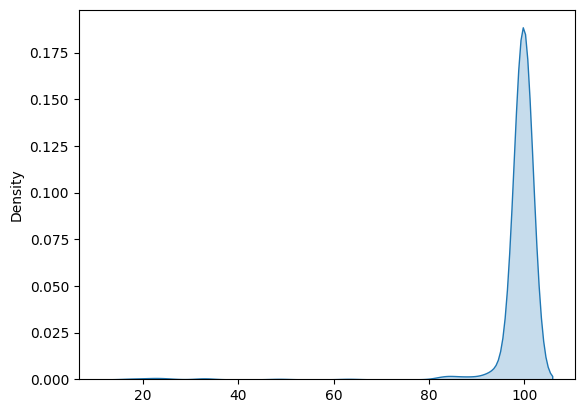

In [43]:
angles = [0, 45, 90, 135, 180, 225, 270, 315]
samples_per_angle = 100

accuracies = []
generated_parameters = []

torch.manual_seed(42)

start_time = timeit.default_timer()
with torch.no_grad():
    for angle in tqdm(angles):
        good_parameters = []
        for i in range(samples_per_angle):
            X, y = get_moons_dataset()
            X_rotated = torch.tensor(rotate(X, angle), dtype=torch.float32)
            a = torch.tensor([angle * math.pi / 180])
            sin = torch.sin(a)
            cos = torch.cos(a)
            center = torch.stack([cos, sin], dim=1)
            z = eight_normal_sample(center, scale=3, var=0.1)
            sample = autoencoder.decoder(z).squeeze()

            X, y = get_moons_dataset()
            X_rotated = rotate(X, angle)
            X_rotated = torch.tensor(X_rotated, dtype=torch.float32)

            accuracy = get_accuracy(sample, X_rotated, y)
            accuracies.append(accuracy)
            if(accuracy > 80):
                good_parameters.append(sample)
        
        generated_parameters.append(good_parameters)

elapsed_time = timeit.default_timer() - start_time
print(f"Time to generate {samples_per_angle*len(angles)} samples:", elapsed_time)

average_distances = []
for params in generated_parameters:
    params = torch.stack(params)
    dists = torch.cdist(params, params)
    average_dist = torch.mean(dists)
    average_distances.append(average_dist.item())

set_distances_mean = np.mean(average_distances)
set_distances_std = np.std(average_distances)

train_params = []
for params, angle in dataset:
    train_params.append(params)
train_params = torch.stack(train_params)

average_distances = []
for params in generated_parameters:
    params = torch.stack(params)
    closest_vals,_ = find_closest_vectors(params, train_params)
    average = torch.mean(closest_vals)
    average_distances.append(average.item())

closest_distances_mean = np.mean(average_distances)
closest_distances_std = np.std(average_distances)

print("Mean accuracy:", np.mean(accuracies))
print("Standard deviation:", np.std(accuracies))
print("The distance in set:", set_distances_mean, set_distances_std)
print("The distance between generated samples and training samples:", closest_distances_mean, closest_distances_std)
sns.kdeplot(accuracies, fill=True)

In [22]:
a = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float32)
b = torch.tensor([[1, 2, 3], [4, 5, 6]], dtype=torch.float32)
distances = torch.cdist(a,b)
print(np.mean(distances.numpy()))

2.598076


In [8]:
print(np.mean([[1,2,3],[2,3,4]]))

2.5


  0%|          | 0/8 [00:00<?, ?it/s]

Mean accuracy: 97.0725
Standard deviation: 4.931649698630268
The average distance between generated samples: 5.776980992406607


<Axes: ylabel='Density'>

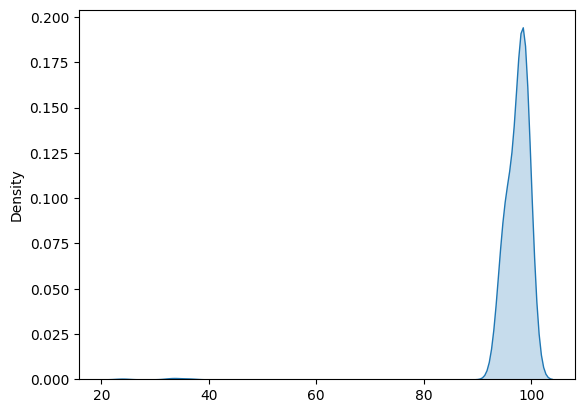

In [56]:
autoencoder = VAE(in_out_dim, latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

accuracies = []
angles = [45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]
total_average_distance = 0
torch.manual_seed(42)


with torch.no_grad():
    for angle in tqdm(angles):
        good_parameters = []
        for i in range(100):
            X, y = get_moons_dataset()
            X_rotated = torch.tensor(rotate(X, angle), dtype=torch.float32)
            a = torch.tensor([angle * math.pi / 180])
            sin = torch.sin(a)
            cos = torch.cos(a)
            center = torch.stack([cos, sin], dim=1)
            z = eight_normal_sample(center, scale=3, var=0.1)
            sample = autoencoder.decoder(z).squeeze()
            accuracy = get_accuracy(sample, X_rotated, y)
            accuracies.append(accuracy)
            if(accuracy > 80):
                good_parameters.append(sample)
        
        average_distance = average_distance_in_set(good_parameters)
        total_average_distance = (total_average_distance + average_distance)/2
    

print("Mean accuracy:", np.mean(accuracies))
print("Standard deviation:", np.std(accuracies))
print("The average distance between generated samples:", total_average_distance)
sns.kdeplot(accuracies, fill=True)

## Distance between generated and training samples

In [57]:
def find_closest_vectors_batched(dataset_train, dataset_test, batch_size=100):
    """
    Finds the closest vectors in dataset_train for each vector in dataset_test using batching.
    Args:
        dataset_train: Tensor of shape (N_train, D)
        dataset_test: Tensor of shape (N_test, D)
        batch_size: Size of batches to process dataset_test
    Returns:
        closest_vectors: Tensor of shape (N_test, D)
        closest_indices: Tensor of shape (N_test,)
    """
    closest_vectors = []
    closest_indices = []
    all_distances = []
    for i in range(0, len(dataset_test), batch_size):
        batch_test = dataset_test[i:i + batch_size] 
        distances = torch.cdist(batch_test, dataset_train, p=2)
        
        batch_indices = torch.argmin(distances, dim=1)
        batch_vectors = dataset_train[batch_indices] 
        
        all_distances.append(distances)
        closest_vectors.append(batch_vectors)
        closest_indices.append(batch_indices)
    
    closest_vectors = torch.cat(closest_vectors, dim=0)
    closest_indices = torch.cat(closest_indices, dim=0)
    average_distance = torch.stack(all_distances).mean()
    distances_std = torch.stack(all_distances).std()
    average_closest_distance = torch.norm(dataset_test - closest_vectors, dim=1).mean()

    return closest_vectors, closest_indices, average_distance, distances_std, average_closest_distance

In [15]:
train_list = []
sample_list = []

for parameters, angle in train_dataset:
    train_list.append(parameters)


X, y = get_moons_dataset()

torch.manual_seed(42)
with torch.no_grad():
    for i in tqdm(range(100)):
        angle = np.random.randint(0, 360)
        X_rotated = torch.tensor(rotate(X, angle), dtype=torch.float32)
        a = torch.tensor([angle * math.pi / 180])
        sin = torch.sin(a)
        cos = torch.cos(a)
        center = torch.stack([cos, sin], dim=1)
        sample = eight_normal_sample(center, scale=3, var=0.1)
        reconstructed = autoencoder.decoder(sample).squeeze()
        sample_list.append(reconstructed)
    

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
closest_vectors, closest_indices, average_distance, distances_std = find_closest_vectors_batched(torch.stack(train_list), torch.stack(sample_list))

In [18]:
print(average_distance)
print(distances_std)

print(sample_list[3])
print(closest_vectors[3])

tensor(332.5921)
tensor(3127.7820)
tensor([ 3.5989, -1.0227,  0.4090, -0.4195,  0.3747,  1.2491,  2.2936, -3.3788,
         3.0870, -1.1908, -2.6542,  3.7727, -0.5235, -0.7089, -1.4341,  0.0176,
         1.1253, -1.3725, -2.9981, -2.3274, -1.1628, -2.5657, -2.1196,  0.1210,
         2.6047, -1.2197, -0.6448, -2.0570, -2.6139,  2.1587,  1.8984, -1.6547,
        -2.7704])
tensor([ 3.2497, -1.1255, -0.1596,  0.0376, -1.6428,  3.0693,  3.1893, -4.0471,
         0.2334, -0.0184, -2.5369,  2.0949, -0.1159, -0.0952, -3.7752,  1.1150,
         1.7375, -0.6755, -2.1674, -2.9595, -0.9598, -1.6071, -0.9258,  1.7075,
         2.2861,  0.2240,  3.3700, -4.0501,  0.2976,  3.3230, -0.3835, -1.9652,
        -0.8683])


In [50]:
autoencoder = VAE(in_out_dim, latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

sample_list = []

for i in tqdm(range(1000)):
    angle = np.random.randint(0, 360)
    X_rotated = torch.tensor(rotate(X, angle), dtype=torch.float32)
    a = torch.tensor([angle * math.pi / 180])
    sin = torch.sin(a)
    cos = torch.cos(a)
    center = torch.stack([cos, sin], dim=1)
    sample = eight_normal_sample(center, scale=3, var=0.1)
    reconstructed = autoencoder.decoder(sample).squeeze()
    sample_list.append(reconstructed)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Distance between generated samples

In [ ]:
def find_closest_vectors_batched(dataset_train, dataset_test, batch_size=100):
    """
    Finds the closest vectors in dataset_train for each vector in dataset_test using batching.
    Args:
        dataset_train: Tensor of shape (N_train, D)
        dataset_test: Tensor of shape (N_test, D)
        batch_size: Size of batches to process dataset_test
    Returns:
        closest_vectors: Tensor of shape (N_test, D)
        closest_indices: Tensor of shape (N_test,)
    """
    closest_vectors = []
    closest_indices = []
    all_distances = []
    for i in range(0, len(dataset_test), batch_size):
        batch_test = dataset_test[i:i + batch_size] 
        distances = torch.cdist(batch_test, dataset_train, p=2)
        
        batch_indices = torch.argmin(distances, dim=1)
        batch_vectors = dataset_train[batch_indices] 
        
        all_distances.append(distances)
        closest_vectors.append(batch_vectors)
        closest_indices.append(batch_indices)
    
    closest_vectors = torch.cat(closest_vectors, dim=0)
    closest_indices = torch.cat(closest_indices, dim=0)
    average_distance = torch.stack(all_distances).mean()
    distances_std = torch.stack(all_distances).std()

    return closest_vectors, closest_indices, average_distance, distances_std

In [ ]:
autoencoder = VAE(in_out_dim, latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

accuracies = []
angles = [0, 45, 90, 135, 180, 225, 270, 315]
generated_samples = []
torch.manual_seed(42)
with torch.no_grad():
    for angle in tqdm(angles):
    
        for i in tqdm(range(100)):
            X, y = get_moons_dataset()
            X_rotated = torch.tensor(rotate(X, angle), dtype=torch.float32)
            a = torch.tensor([angle * math.pi / 180])
            sin = torch.sin(a)
            cos = torch.cos(a)
            center = torch.stack([cos, sin], dim=1)
            sample = eight_normal_sample(center, scale=3, var=0.1)
            reconstructed = autoencoder.decoder(sample).squeeze()
            generated_samples.append(reconstructed)


    

print("Mean accuracy:", np.mean(accuracies))
print("STD:", np.std(accuracies))
sns.kdeplot(accuracies, fill=True)